Data from kaggle dataset: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation

I used U-Net with 6 convolutional layers and 5 upsampling convolutional layers

In [ ]:
import pandas as pd
import numpy as np
import time
import gc
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
from PIL import Image
import pathlib
import random

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# All important imports
from keras.models import Model

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sorokinmaksim","key":"9537fa921e351600c84c9f61d1f01441"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Apr  5 08:03 kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d faizalkarim/flood-area-segmentation

 92% 98.0M/107M [00:00<00:00, 169MB/s]
100% 107M/107M [00:00<00:00, 150MB/s] 


In [ ]:
! unzip /content/flood-area-segmentation.zip

Archive:  /content/flood-area-segmentation.zip
  inflating: Image/0.jpg             
  inflating: Image/1.jpg             
  inflating: Image/10.jpg            
  inflating: Image/1000.jpg          
  inflating: Image/1001.jpg          
  inflating: Image/1002.jpg          
  inflating: Image/1003.jpg          
  inflating: Image/1004.jpg          
  inflating: Image/1005.jpg          
  inflating: Image/1006.jpg          
  inflating: Image/1007.jpg          
  inflating: Image/1008.jpg          
  inflating: Image/1009.jpg          
  inflating: Image/1010.jpg          
  inflating: Image/1011.jpg          
  inflating: Image/1012.jpg          
  inflating: Image/1013.jpg          
  inflating: Image/1014.jpg          
  inflating: Image/1015.jpg          
  inflating: Image/1016.jpg          
  inflating: Image/1017.jpg          
  inflating: Image/1018.jpg          
  inflating: Image/1019.jpg          
  inflating: Image/1020.jpg          
  inflating: Image/1021.jpg          
  i

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"[INFO] importing directory: {dirname}\n")
    with tqdm(total=len(filenames)) as t:
        for filename in filenames:
            t.update(1)

In [ ]:
imagesPath = "/content/Image"
masksPath = "/content/Mask"

In [ ]:
images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [ ]:
X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    path = imagesPath + "/" + id_
    img = Image.open(path)
    img = np.array(img)
    img = resize(img, (256, 256, 3), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_.split(".")[0] + ".png")
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask

Resizing training images and masks


100%|██████████| 290/290 [01:47<00:00,  2.71it/s]


In [ ]:
print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (290, 256, 256, 3)
Y.shape: (290, 256, 256, 1)


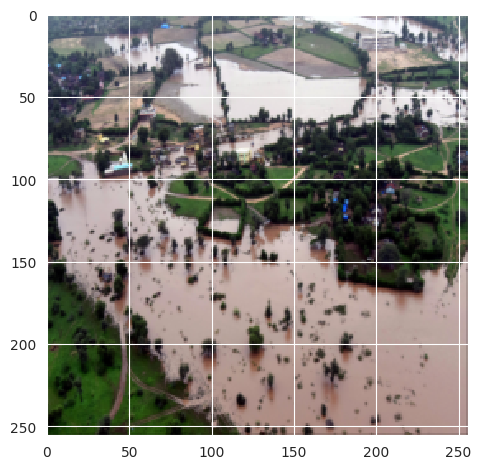

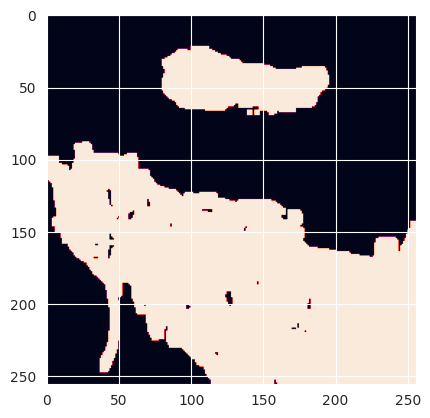

In [ ]:
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

In [ ]:

# Input image
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

modelUNet = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

modelUNet.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks=[
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(X, Y, validation_split=0.1, batch_size=8, epochs=50, callbacks=callbacks)

Epoch 1/50
33/33 [==============================] - 28s 244ms/step - loss: 0.6912 - accuracy: 0.5950 - val_loss: 0.6691 - val_accuracy: 0.7532
Epoch 2/50
33/33 [==============================] - 4s 136ms/step - loss: 0.5890 - accuracy: 0.7253 - val_loss: 0.4830 - val_accuracy: 0.7834
Epoch 3/50
33/33 [==============================] - 4s 136ms/step - loss: 0.5363 - accuracy: 0.7513 - val_loss: 0.4897 - val_accuracy: 0.7762
Epoch 4/50
33/33 [==============================] - 4s 135ms/step - loss: 0.5080 - accuracy: 0.7763 - val_loss: 0.4743 - val_accuracy: 0.8003
Epoch 5/50
33/33 [==============================] - 5s 137ms/step - loss: 0.5431 - accuracy: 0.7471 - val_loss: 0.4682 - val_accuracy: 0.7984
Epoch 6/50
33/33 [==============================] - 4s 137ms/step - loss: 0.4917 - accuracy: 0.7767 - val_loss: 0.4392 - val_accuracy: 0.8092
Epoch 7/50
33/33 [==============================] - 4s 135ms/step - loss: 0.4547 - accuracy: 0.7966 - val_loss: 0.4355 - val_accuracy: 0.8088
Epoch

In [ ]:

def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

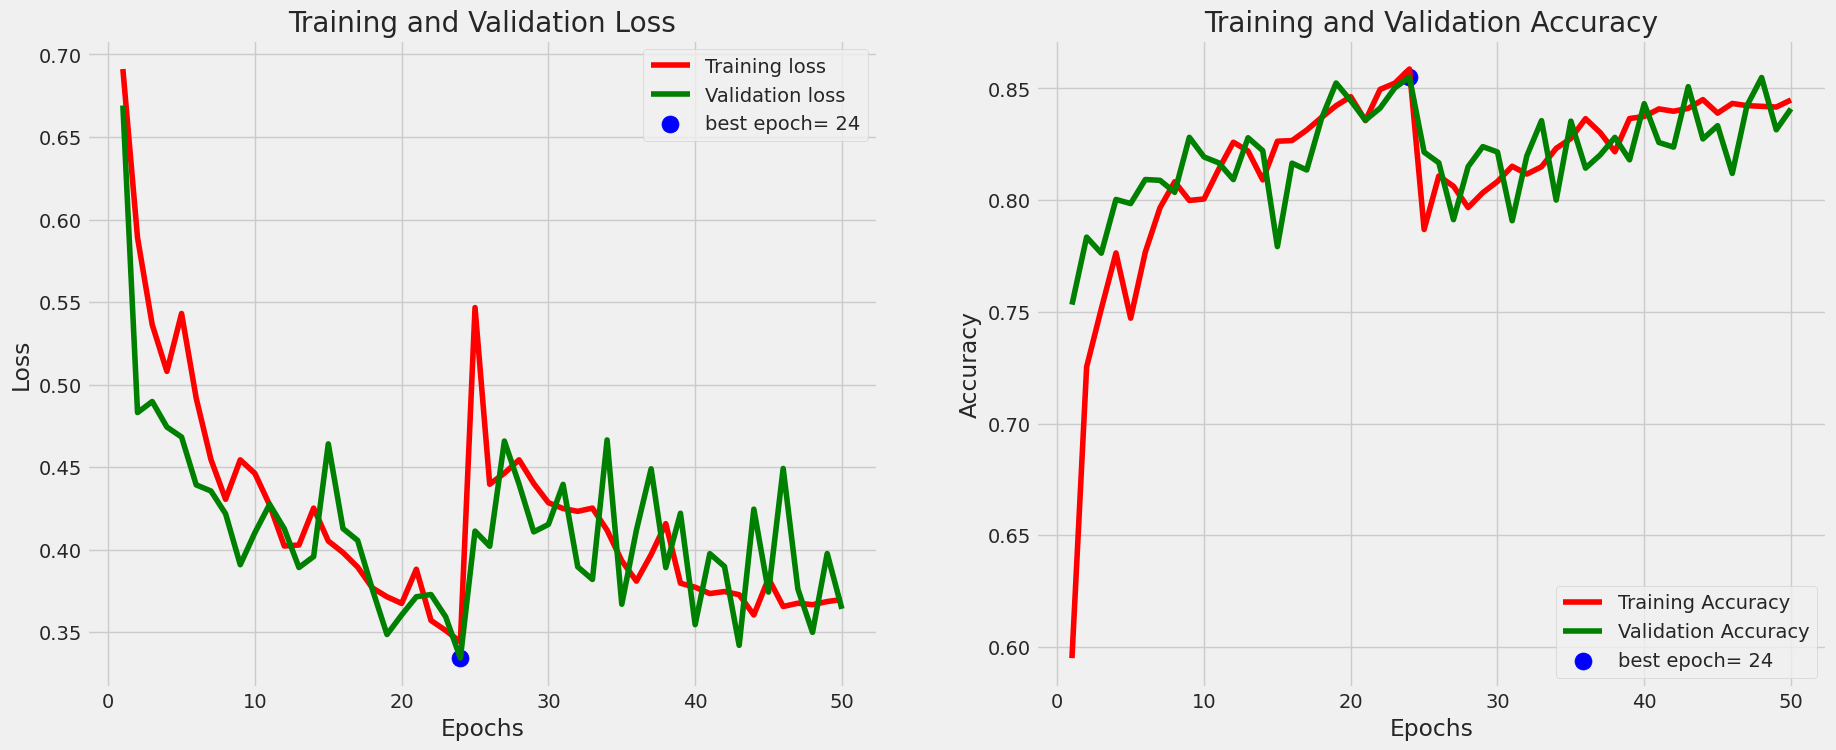

In [ ]:
plot_training(results)

In [ ]:
modelUNet.evaluate(X, Y)

10/10 [==============================] - 4s 166ms/step - loss: 0.3789 - accuracy: 0.8366


[0.3788798451423645, 0.8365593552589417]

<Figure size 3000x3000 with 0 Axes>

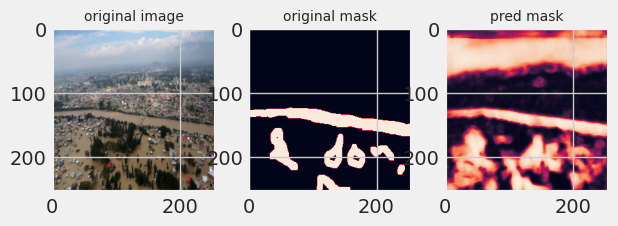

In [ ]:

plt.figure(figsize=(30,30))

ind = random.randint(0, len(X))
img = X[ind]
predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask))